# Load modules

In [1]:
# pip install seaborn

In [2]:
# pip install pyabc

In [3]:
# pip install xlrd

In [4]:
import random
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
from scipy import stats
from IPython.display import Image
from functools import partial
import pickle
import pandas as pd
import seaborn as sns
from pyabc import (ABCSMC,
                   RV, Distribution,
                   MedianEpsilon,
                   transition,
                   epsilon,
                   sampler,
                   AdaptivePNormDistance)
import pyabc.visualization
from pyabc.visualization import (plot_kde_1d,
                                 plot_kde_2d,
                                 plot_kde_matrix,
                                 plot_epsilons,
                                 plot_effective_sample_sizes)

import math

# Stem cell hierarchy

As Lan et al. proposed, a stem cell hierachy in Glioblastoma development consists of three different cell types: stem cell, progenitor cell and differentiated cell. As shown in Figure, a stem cell could divide into either two stem cells (symmetrical cell division) or one stem cell and one progenitor cell (asymmetrical cell division); a progenitor cell could either divide into two progenitor cells (cell division) or differentiate into one differentiated cell (cell division); and a differentiated cell will eventually undergo cell apoptosis.

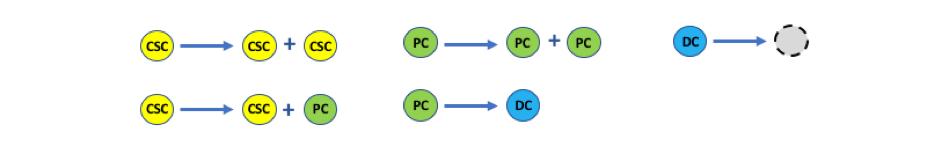

In [5]:
Image("Lan.png")

In the following clonalSizeSimulation/clonalGrowthSimulation, stochastic simulation is applied to five reactions:

    Reaction 1: S > S + S,    rate of reaction k1 = omega * probability
    Reaction 2: S > S + P,    rate of reaction k2 = omega * (1 - probability)
    Reaction 3: P > P + P,    rate of reaction k3 = lambda * 0.5
    Reaction 4: P > D,        rate of reaction k4 = lambda * 0.5
    Reaction 5: D > none,     rate of reaction k5 = gamma

# Simulation for a single passage

In [6]:
# parameters = {"Omega":0.15,"Probability":0.15,"Lambda":1.0,"Gamma":0.48}

countingTimePoints = np.array([80,65,70])

In [7]:
def clonalGrowth(inject, parameters, time):
    k1 = parameters["Omega"] * parameters["Probability"]
    k2 = parameters["Omega"] * (1 - parameters["Probability"])
    k3 = 0.5
#     *parameters["Lambda"]
    k4 = 0.5
#     *parameters["Lambda"]
    k5 = 0.48
#     parameters["Gamma"]
    S = inject["stem"]
    P = inject["progenitor"]
    D = 0
    reactionTime = 0      
    cont = True  
    while(cont):
        A1 = S*k1
        A2 = S*k2
        A3 = P*k3
        A4 = P*k4
        A5 = D*k5
        A0 = A1 + A2 + A3 + A4 + A5
#         first random number generator to determine the time of nexr reaction
        if A0 > 0:
            r1 = random.random()
            t = np.log(1/r1)/A0
            if reactionTime + t > time:
                cont = False
            else:
                reactionTime += t
    #             second random number generator to determine which reaction occurs
                r2 = random.random()
                if r2 < A1/A0:
                    S += 1
                elif r2 < (A1+A2+A3)/A0:
                    P += 1
                elif r2 < (A1+A2+A3+A4)/A0:
                    P -= 1
                    D += 1
                else:
                    D -= 1
        else:
            cont = False
    return{"stem":S,"progenitor":P,"differentiated":D}


# Simulation for a serial passage

In [8]:
def transplantation(harvest,transplantationProb):
    stemHarvest = harvest["stem"]
    proHarvest = harvest["progenitor"]
    totalHarvest = stemHarvest + proHarvest
    stemReinject = 0
    proReinject = 0
    quieReinject = 0
    if totalHarvest > 0:
        stemProb = stemHarvest/totalHarvest
        proProb = proHarvest/totalHarvest
        stemReinject += np.random.binomial(n=totalHarvest, p=stemProb*transplantationProb)
        proReinject += np.random.binomial(n=totalHarvest, p=proProb*transplantationProb)
    else:
        pass
    return{"stem":stemReinject, "progenitor":proReinject}

def passageExpansion(primaryInject, testParameters, transplantationProb, seed):
    np.random.seed(seed)
    primaryHarvest = clonalGrowth(primaryInject, testParameters,countingTimePoints[0])
    secondaryInject = transplantation(primaryHarvest,transplantationProb)
    secondaryHarvest = clonalGrowth(secondaryInject, testParameters,countingTimePoints[1])
    tertiaryInject = transplantation(secondaryHarvest,transplantationProb)
    tertiaryHarvest = clonalGrowth(tertiaryInject, testParameters,countingTimePoints[2])
    S = np.array([primaryHarvest["stem"],secondaryHarvest["stem"],tertiaryHarvest["stem"]])
    P = np.array([primaryHarvest["progenitor"],secondaryHarvest["progenitor"],tertiaryHarvest["progenitor"]])
    D = np.array([primaryHarvest["differentiated"],secondaryHarvest["differentiated"],tertiaryHarvest["differentiated"]])
    return{"stem":S, "progenitor":P, "differentiated":D}

# Simulation for multiple clones

In [9]:
def multiGrowthSimulation(testParameters):
    simulation = 10000
    s = np.random.binomial(n=simulation, p=0.15)
    timeRange = int(len(countingTimePoints))
    multiGrowth = np.zeros((simulation,3,timeRange))
    print("Omega = "+str(testParameters["Omega"])+", Probability = "+str(testParameters["Probability"]))
    for i in range(simulation):
        if i < s:
            clone = passageExpansion({"stem":1,"progenitor":0}, testParameters, 0.37, i)
        else:
            clone = passageExpansion({"stem":0,"progenitor":1}, testParameters, 0.37, i)
        multiGrowth[i][0][:] = clone["stem"]
        multiGrowth[i][1][:] = clone["progenitor"]
        multiGrowth[i][2][:] = clone["differentiated"]
    return(multiGrowth)

def barFreqDistribution(testParameters):
    multiGrowth = multiGrowthSimulation(testParameters)
    clones = len(multiGrowth)
    primary = np.zeros(clones)
    secondary = np.zeros(clones)
    tertiary = np.zeros(clones)
    for clone in range(clones):
        primary[clone] = sum(np.array([multiGrowth[clone][cellType][0] for cellType in range(3)]))
        secondary[clone] = sum(np.array([multiGrowth[clone][cellType][1] for cellType in range(3)]))
        tertiary[clone] = sum(np.array([multiGrowth[clone][cellType][2] for cellType in range(3)]))
    primaryBarFreq = primary/sum(primary)
    secondaryBarFreq = secondary/sum(secondary)
    tertiaryBarFreq = tertiary/sum(tertiary)
    return{"primary":primaryBarFreq, "secondary":secondaryBarFreq, "tertiary": tertiaryBarFreq}


In [10]:
# %time multiGrowth = multiGrowthSimulation(parameters)

In [11]:
# %time barFreqSim = barFreqDistribution(parameters)

# search for parameters by comparing with Lan et al.'s experimental data

In [12]:
experiment = pd.read_excel("Table_1_experimental_clonal_size.xlsx")
experiment.head()

,Barcode,(1)719 Ipsi,(1)719 Contra,"(1,1V)719 Ipsi","(1,1V)719 Contra","(1,2V)719 Ipsi","(1,2V)719 Contra","(1,3V)719 Ipsi","(1,3V)719 Contra","(1,1T)719 Ipsi",...,"(1,1T,1V)719 Ipsi","(1,1T,1V)719 Contra","(1,1T,2V)719 Ipsi","(1,1T,2V)719 Contra","(1,1T,1T)719 Ipsi","(1,1T,1T)719 Contra","(1,1T,2T)719 Ipsi","(1,1T,2T)719 Contra","(1,1T,3T)719 Ipsi","(1,1T,3T)719 Contra"
0,AAATCAAGATCGAAACTGGTCAAACTG,0.001608,0.000614,0.002460,0.002479,0.002866,0.001103,0.004939,0.006328,0.00000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.005538,0.0,0.0,0.003078
1,AAATCAGGATGCAAACAGGTGTAACGG,0.001913,0.002575,0.003878,0.004407,0.003090,0.003762,0.000000,0.000000,0.00000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
2,AAATCCAGATCGAAATGGGTTTAACTT,0.002520,0.000000,0.005109,0.003288,0.005141,0.000000,0.002147,0.002167,0.00199,...,0.000000,0.0,0.003741,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
3,AAATCCAGATGGAAAGAGGTAGAACCC,0.001200,0.000743,0.001532,0.001386,0.002106,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
4,AAATCTCGATGGAAATCGGTCAAACAA,0.002975,0.001134,0.004104,0.002142,0.009155,0.001001,0.009424,0.010710,0.00199,...,0.002222,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000


In [13]:
np.shape(experiment)

(2070, 39)

In [14]:
passage = experiment.columns
passage[1:]

Index(['(1)719 Ipsi', '(1)719 Contra', '(1,1V)719 Ipsi', '(1,1V)719 Contra',
       '(1,2V)719 Ipsi', '(1,2V)719 Contra', '(1,3V)719 Ipsi',
       '(1,3V)719 Contra', '(1,1T)719 Ipsi', '(1,1T)719 Contra',
       '(1,2T)719 Ipsi', '(1,2T)719 Contra', '(1C,1)719 Ipsi',
       '(1C,1)719 Contra', '(1C,2)719 Ipsi', '(1C,2)719 Contra',
       '(1,2V,1)719 Ipsi', '(1,2V,1)719 Contra', '(1,2V,2)719 Ipsi',
       '(1,2V,2)719 Contra', '(1,2V,3)719 Ipsi', '(1,2V,3)719 Contra',
       '(1,3V,1V)719 Ipsi', '(1,3V,1V)719 Contra', '(1,3V,2V)719 Ipsi',
       '(1,3V,2V)719 Contra', '(1,3V,1T)719 Ipsi', '(1,3V,1T)719 Contra',
       '(1,1T,1V)719 Ipsi', '(1,1T,1V)719 Contra', '(1,1T,2V)719 Ipsi',
       '(1,1T,2V)719 Contra', '(1,1T,1T)719 Ipsi', '(1,1T,1T)719 Contra',
       '(1,1T,2T)719 Ipsi', '(1,1T,2T)719 Contra', '(1,1T,3T)719 Ipsi',
       '(1,1T,3T)719 Contra'],
      dtype='object')

In [15]:
primaryExpBarFreq = np.vstack([experiment["(1)719 Ipsi"], experiment["(1)719 Contra"]])
secondaryExpBarFreq = np.vstack([
#     experiment["(1,1V)719 Ipsi"], experiment["(1,1V)719 Contra"],
                       experiment["(1,2V)719 Ipsi"], experiment["(1,2V)719 Contra"],
#                        experiment["(1,3V)719 Ipsi"], experiment["(1,3V)719 Contra"],
#                        experiment["(1,1T)719 Ipsi"], experiment["(1,1T)719 Contra"],
#                        experiment["(1,2T)719 Ipsi"], experiment["(1,2T)719 Contra"],
#                        experiment["(1C,1)719 Ipsi"], experiment["(1C,1)719 Contra"],
#                        experiment["(1C,2)719 Ipsi"], experiment["(1C,2)719 Contra"]
                      ])
tertiaryExpBarFreq = np.vstack([experiment["(1,2V,1)719 Ipsi"], experiment["(1,2V,1)719 Contra"]
#                       ,experiment["(1,2V,2)719 Ipsi"], experiment["(1,2V,2)719 Contra"],
#                       experiment["(1,2V,3)719 Ipsi"], experiment["(1,2V,3)719 Contra"],
#                       experiment["(1,3V,1V)719 Ipsi"], experiment["(1,3V,1V)719 Contra"],
#                       experiment["(1,3V,2V)719 Ipsi"], experiment["(1,3V,2V)719 Contra"],
#                       experiment["(1,3V,1T)719 Ipsi"], experiment["(1,3V,1T)719 Contra"],
#                       experiment["(1,1T,1V)719 Ipsi"], experiment["(1,1T,1V)719 Contra"],
#                       experiment["(1,1T,2V)719 Ipsi"], experiment["(1,1T,2V)719 Contra"],
#                       experiment["(1,1T,1T)719 Ipsi"], experiment["(1,1T,1T)719 Contra"],
#                       experiment["(1,1T,2T)719 Ipsi"], experiment["(1,1T,2T)719 Contra"],
#                       experiment["(1,1T,3T)719 Ipsi"], experiment["(1,1T,3T)719 Contra"]
                     ])

primaryExp = np.array([np.mean(i) for i in np.transpose(primaryExpBarFreq)])
secondaryExp = np.array([np.mean(i) for i in np.transpose(secondaryExpBarFreq)])
tertiaryExp = np.array([np.mean(i) for i in np.transpose(tertiaryExpBarFreq)])


In [16]:
def setConstantBins(exp):
    binWidth = max(exp)/100
    bins = np.array([(binWidth*n) for n in range(101)])
    return(bins)

priBins = setConstantBins(primaryExp)
secBins = setConstantBins(secondaryExp)
terBins = setConstantBins(tertiaryExp)

def binnedBarcodeFrequency(barFreq,bins):
    binnedBarFreq = np.zeros(len(bins)-1)
    for B in range(len(bins)-1):
        index = np.all([[bins[B] <= barFreq], [bins[B+1] > barFreq]], axis = 0)
        binnedBarFreq[B] = sum(index[0])/len(barFreq)
    return(binnedBarFreq)

primaryExpBinned = binnedBarcodeFrequency(primaryExp,priBins)
secondaryExpBinned = binnedBarcodeFrequency(secondaryExp,secBins)
tertiaryExpBinned = binnedBarcodeFrequency(tertiaryExp,terBins)

def normalisation(probability):
    return(probability/sum(probability))

primaryExpNorm = normalisation(primaryExpBinned[1:])
secondaryExpNorm = normalisation(secondaryExpBinned[1:])
tertiaryExpNorm = normalisation(tertiaryExpBinned[1:])

exp = np.array([normalisation(primaryExpBinned[1:]),normalisation(secondaryExpBinned[1:]), normalisation(tertiaryExpBinned[1:])])

expBarFreq = {"barcodeFrequency":exp}

In [17]:
def aveSimulation(parameters,re):
    simulation = np.zeros((3,99))
    repeat = np.zeros((3,re,99))
    for R in range(re):
        sim = noisySimulation(parameters)
        for T in range(len(sim)):
            repeat[T][R][:] = sim[T]
                
        for t in range(len(sim)):
            harv = np.transpose(repeat[t])
            simulation[t][:] = np.array([np.mean(p) for p in harv])
    return(simulation)

# def determineTestParameters(testParameters): 
#     barFreq = barFreqDistribution(testParameters)
#     primaryBarFreq = barFreq["primary"]
#     secondaryBarFreq = barFreq["secondary"]
#     tertiaryBarFreq = barFreq["tertiary"]    
#     primaryBinned = binnedBarcodeFrequency(primaryBarFreq,priBins)
#     secondaryBinned = binnedBarcodeFrequency(secondaryBarFreq,secBins)
#     tertiaryBinned = binnedBarcodeFrequency(tertiaryBarFreq,terBins)
#     primaryNorm = normalisation(primaryBinned[1:])
#     secondaryNorm = normalisation(secondaryBinned[1:])
#     tertiaryNorm = normalisation(tertiaryBinned[1:])
#     return{"barcodeFrequency": np.array([primaryNorm, secondaryNorm, tertiaryNorm])}

def determineTestParameters(testParameters): 
    repeat = 1
    primary = np.zeros((repeat,99))
    secondary = np.zeros((repeat,99))
    tertiary = np.zeros((repeat,99))
    for R in range(repeat):
        barFreq = barFreqDistribution(testParameters)
        primaryBarFreq = barFreq["primary"]
        secondaryBarFreq = barFreq["secondary"]
        tertiaryBarFreq = barFreq["tertiary"]    
        primaryBinned = binnedBarcodeFrequency(primaryBarFreq,priBins)
        secondaryBinned = binnedBarcodeFrequency(secondaryBarFreq,secBins)
        tertiaryBinned = binnedBarcodeFrequency(tertiaryBarFreq,terBins)
        primary[R][:] = normalisation(primaryBinned[1:])
        secondary[R][:] = normalisation(secondaryBinned[1:])
        tertiary[R][:] = normalisation(tertiaryBinned[1:])
    primaryAve = np.array([np.mean(p) for p in np.transpose(primary)])
    secondaryAve = np.array([np.mean(s) for s in np.transpose(secondary)])
    tertiaryAve = np.array([np.mean(t) for t in np.transpose(tertiary)])
    return{"barcodeFrequency": np.array([primaryAve, secondaryAve, tertiaryAve])}

%time simBarFreq = determineTestParameters({"Omega":0.15,"Probability":0.15,"Lambda":1.0,"Gamma":0.48})

Omega = 0.15, Probability = 0.15
CPU times: user 25.1 s, sys: 0 ns, total: 25.1 s
Wall time: 25.1 s


In [18]:
# def SimExpPresent(x,sim,exp,harv):
#     title = np.array(["primary","secondary","tertiary"])
#     plt.plot(x[2:], exp["barcodeFrequency"][harv], label = "experiment")
#     plt.plot(x[2:], sim["barcodeFrequency"][harv], label = "simulation")
#     plt.xlable("barcode frequency")
#     plt.title(title[harv])
#     plt.legend()

# SimExpPresent(priBins,simBarFreq,expBarFreq,0)

In [19]:
# def noisySimulation(testParameters): 
#     barFreq = barFreqDistribution(testParameters)
#     primaryBarFreq = barFreq["primary"]
#     secondaryBarFreq = barFreq["secondary"]
#     tertiaryBarFreq = barFreq["tertiary"]
#     primaryBinned = binnedBarcodeFrequency(primaryBarFreq,priBins)
#     secondaryBinned = binnedBarcodeFrequency(secondaryBarFreq,secBins)
#     tertiaryBinned = binnedBarcodeFrequency(tertiaryBarFreq,terBins)
#     primaryNorm = normalisation(primaryBinned[1:])
#     secondaryNorm = normalisation(secondaryBinned[1:])
#     tertiaryNorm = normalisation(tertiaryBinned[1:])
#     return(np.array([primaryNorm, secondaryNorm, tertiaryNorm]))

# def aveSimulationNoise(parameters, n, re):
#     simulation = np.zeros((n,3,99))
#     repeat = np.zeros((3,re,99))
#     for i in range(n):
#         for R in range(re):
#             sim = noisySimulation(parameters)
#             for T in range(len(sim)):
#                 repeat[T][R][:] = sim[T]
                
#         for t in range(len(sim)):
#             harv = np.transpose(repeat[t])
#             simulation[i][t][:] = np.array([np.mean(p) for p in harv])
#     return(simulation)

# def simulationNoise(parameters, n,):
#     simulation = np.zeros((n,3,99))
#     for i in range(n):
#         sim = noisySimulation(parameters)
#         for t in range(len(sim)):
#             simulation[i][t][:] = sim[t]
#     return(simulation)
            
# %time simNoise = simulationNoise(parameters, 10)   
# print(np.shape(simNoise))

In [20]:
# def ksStatistic(o,m):
#     #print("%dx%d\n" % (len(o), len(m)) )
#     k,p = stats.ks_2samp(o,m)
#     return(k)

def Euclidean(o,m):
    return(math.sqrt(sum([(a - b) ** 2 for a, b in zip(o, m)])))

def Hellinger(o,m):
    return(math.sqrt(sum([(math.sqrt(a)-math.sqrt(b))**2 for a,b in zip(o,m)])/2))


In [21]:
def geometricBinning():
    nBin = int(round(np.log(99)/np.log(2)+0.5))
    binSize = np.append([0],[2**n for n in range(nBin)])
    bins = np.cumsum(binSize)
    return(bins)

def arithmeticBinning():
    nBin = int(round(np.sqrt(8*99 + 1)/2))
    binSize = np.array([n for n in range(nBin+1)])
    bins = np.cumsum(binSize)
    return(bins)

# def binnedProbability(prob,bins):
#     binnedProb = np.array([sum(prob[bins[n]:bins[n+1]]) for n in range(len(bins)-1)])
#     return(binnedProb)

# def binAllProb(sim, binning):
#     bins = binning()
#     shape = np.shape(sim)
#     binnedprob = np.zeros((shape[0], shape[1], len(bins)-1))
#     for a in range(shape[0]):
#         for b in range(shape[1]):
#             binnedprob[a][b][:] = binnedProbability(sim[a][b],bins)
#     return(binnedprob)

# %time binnedNoise = binAllProb(simNoise, geometricBinning)

In [22]:
def measureDistance(f,sim,data): 
    results = [f(sim[i],data[i]) for i in range(len(sim))]
    return(sum(results))

def DistanceAfterBinning(sim,exp):
    f = Hellinger
    simBarFreq = sim["barcodeFrequency"]
    expBarFreq = exp["barcodeFrequency"]
    
#     def binnedProbability(prob,bins):
#         binnedProb = np.array([sum(prob[bins[n]:bins[n+1]]) for n in range(len(bins)-1)])
#         return(binnedProb)
    
#     def binbarFreq(data, binning):
#         bins = binning()
#         binnedprob = np.zeros((len(data), len(bins)-1))
#         for a in range(len(data)):
#             binnedprob[a][:] = binnedProbability(data[a],bins)
#         return(binnedprob)
    
#     simBinned = binbarFreq(simBarFreq, geometricBinning)
#     expBinned = binbarFreq(expBarFreq, geometricBinning)
#     return(measureDistance(Hellinger, simBinned, expBinned))
    result = measureDistance(Hellinger, simBarFreq, expBarFreq)
    print(result)
    return(result)

In [23]:
# def noisePresent(noise,f):
#     n = len(noise)
#     result = []
#     for a in range(n):
#         for b in range(n):
#             if a < b:
#                 d = measureDistance(f,noise[a], noise[b])
#                 result.append(d)
#             else:
#                 pass
#     return(result)

# %time distance = noisePresent(binnedNoise, Euclidean)
# plt.hist(distance)

Now we are search for the best fitting parameters using pyABC.

In [24]:
# limits = dict(Omega = (0, 0.3), 
#               Probability = (0, 0.2)) 
# #               Lambda = (0, 1.5),
# #               Gamma = (0, 3))

# parameter_prior = Distribution(**{key: RV("uniform", a, b - a)
#                         for key, (a,b) in limits.items()})

# [pyabc.Distribution(x=pyabc.RV("norm", mu_x_1, sigma)),pyabc.Distribution(x=pyabc.RV("norm", mu_x_2, sigma))
 
parameter_prior = Distribution(Omega=RV("uniform",0,0.3),
                              Probability=RV("uniform", 0, 0.2))

db_path = pyabc.create_sqlite_db_id(file_ = "glioblatomaLanModel_syn.db")

abc = ABCSMC(models = determineTestParameters,
             parameter_priors = parameter_prior,
             distance_function = DistanceAfterBinning, 
             population_size = 50,
             eps = epsilon.ConstantEpsilon(1.5),
#              sampler = sampler.MulticoreEvalParallelSampler,
             transitions = transition.LocalTransition(k_fraction=0.3))

abc.new(db_path, simBarFreq);

INFO:History:Start <ABCSMC(id=17, start_time=2020-02-13 15:13:28.924199, end_time=None)>


In [25]:
# dir(parameter_prior["Gamma"])

In [26]:
# testdist = RV("uniform",0,5)

In [27]:
# x = range(5)
# plt.plot(x,testdist.pdf(x))

In [28]:
h = abc.run(minimum_epsilon=0.6, max_nr_populations=1)

INFO:ABC:t: 0, eps: 1.5.


Omega = 0.029652582312863905, Probability = 0.024466058618872633
Omega = 0.14373039100758364, Probability = 0.1795972311403227
Omega = 0.15399818227465434, Probability = 0.013611305039897825
Omega = 0.20940041503511933, Probability = 0.15685511045147238
Omega = 0.038508656598226665, Probability = 0.03817093531043472
Omega = 0.14140342003661358, Probability = 0.18292539482031092
Omega = 0.14266294724667994, Probability = 0.19255391208125422
Omega = 0.16971512382312598, Probability = 0.04146914012367338
Omega = 0.08744929159570297, Probability = 0.03299250053438712
Omega = 0.16242444993291663, Probability = 0.024652000239821215
Omega = 0.17117217269174037, Probability = 0.08226190255968897
Omega = 0.04068250172842693, Probability = 0.06013197586819932
Omega = 0.21573718382818408, Probability = 0.07564300134857492
Omega = 0.03641311747551842, Probability = 0.15390561498790006
Omega = 0.09538987950469771, Probability = 0.19433610325748074
Omega = 0.18667981970829123, Probability = 0.016113

INFO:ABC:Acceptance rate: 50 / 65 = 7.6923e-01, ESS=5.0000e+01.
INFO:History:Done <ABCSMC(id=17, start_time=2020-02-13 15:13:28.924199, end_time=2020-02-13 15:19:08.410052)>


In [29]:
h.get_all_populations()

,t,population_end_time,samples,epsilon,particles
0,-1,2020-02-13 15:13:28.974301,0,inf,1
1,0,2020-02-13 15:19:08.249125,65,1.5,50


In [30]:
h.total_nr_simulations

65

(array([ 4.,  9., 27.,  0.,  2.,  2.,  1.,  1.,  2.,  2.]),
 array([0.30891203, 0.40985568, 0.51079933, 0.61174299, 0.71268664,
        0.81363029, 0.91457394, 1.0155176 , 1.11646125, 1.2174049 ,
        1.31834855]),
 <a list of 10 Patch objects>)

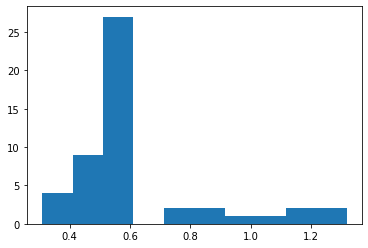

In [31]:
plt.hist(h.get_weighted_distances()["distance"])

In [32]:
h.get_distribution()

(name     Omega  Probability
 id                         
 3018  0.029653     0.024466
 3019  0.143730     0.179597
 3020  0.153998     0.013611
 3021  0.209400     0.156855
 3022  0.038509     0.038171
 3023  0.141403     0.182925
 3024  0.142663     0.192554
 3025  0.169715     0.041469
 3026  0.087449     0.032993
 3027  0.162424     0.024652
 3028  0.171172     0.082262
 3029  0.040683     0.060132
 3030  0.215737     0.075643
 3031  0.036413     0.153906
 3032  0.095390     0.194336
 3033  0.186680     0.016113
 3034  0.247017     0.043721
 3035  0.247017     0.043721
 3036  0.065581     0.006292
 3037  0.247017     0.043721
 3038  0.247017     0.043721
 3039  0.247017     0.043721
 3040  0.247017     0.043721
 3041  0.247017     0.043721
 3042  0.247017     0.043721
 3043  0.247017     0.043721
 3044  0.247017     0.043721
 3045  0.247017     0.043721
 3046  0.247017     0.043721
 3047  0.247017     0.043721
 3048  0.247017     0.043721
 3049  0.247017     0.043721
 3050  0.24701

(array([ 4.,  1.,  1.,  1.,  0.,  4.,  3.,  1.,  2., 33.]),
 array([0.02965258, 0.051389  , 0.07312541, 0.09486182, 0.11659824,
        0.13833465, 0.16007107, 0.18180748, 0.20354389, 0.22528031,
        0.24701672]),
 <a list of 10 Patch objects>)

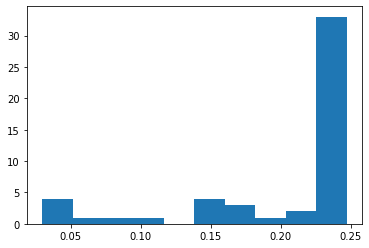

In [33]:
plt.hist(h.get_distribution()[0]["Omega"])

(array([ 5., 36.,  1.,  1.,  1.,  0.,  0.,  1.,  1.,  4.]),
 array([0.0062922 , 0.02509659, 0.04390098, 0.06270537, 0.08150976,
        0.10031415, 0.11911854, 0.13792293, 0.15672732, 0.17553171,
        0.1943361 ]),
 <a list of 10 Patch objects>)

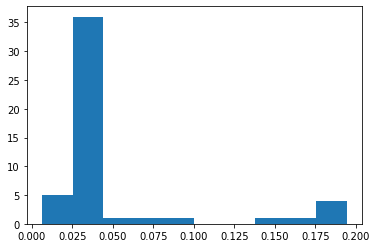

In [34]:
plt.hist(h.get_distribution()[0]["Probability"])

In [35]:
# plt.hist(h.get_distribution()[0]["Lambda"])

In [36]:
# plt.hist(h.get_distribution()[0]["Gamma"])

In [37]:
# def plot_history(history):
#     fig,ax=plt.subplots()
#     for t in range(history.max_t+1):
#         plot_kde_1d(*history.get_distribution(m=0, t=t),
#                     xmin=0, xmax=0.3,
#                     x="Omega", ax=ax,
#                     label="Posterior t={}".format(t))
# #         ax.set_title("Posterior t={}".format(t))
#     ax.legend()
    
#     fig,ax=plt.subplots()
#     for t in range(history.max_t+1):
#         plot_kde_1d(*history.get_distribution(m=0, t=t),
#                     xmin=0, xmax=0.2,
#                     x="Probability", ax=ax,
#                     label="Posterior t={}".format(t))
#     ax.legend()
    
#     fig,ax=plt.subplots()
#     for t in range(history.max_t+1):
#         plot_kde_1d(*history.get_distribution(m=0, t=t),
#                     xmin=0, xmax=1.5,
#                     x="Lambda", ax=ax,
#                     label="Posterior t={}".format(t))
#     ax.legend()
    
#     fig,ax=plt.subplots()
#     for t in range(history.max_t+1):
#         plot_kde_1d(*history.get_distribution(m=0, t=t),
#                     xmin=0, xmax=3,
#                     x="Gamma", ax=ax,
#                     label="Posterior t={}".format(t))
#     ax.legend()

# plot_history(h)

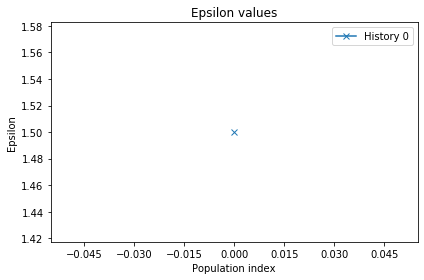

In [38]:
plot_epsilons(h)

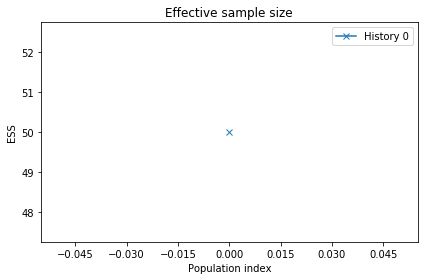

In [39]:
plot_effective_sample_sizes(h)

In [40]:
df, w = h.get_distribution(m=0)
plot_kde_matrix(df, w, limits=limits)

NameError: name 'limits' is not defined